
# KRAS G12D Data Prep: ChEMBL → Cleaning → SELFIES (+ QED/SA)

Fetch **KRAS G12D** inhibitor measurements from ChEMBL, clean molecules with RDKit, standardize activity units to pX (−log10 M), label actives (pX ≥ 6), convert to **SELFIES**, and compute **QED**/**SA** metrics for quick medicinal‑chemistry assessment.

> References (how we search): KRAS target `CHEMBL2189121` and assays with description containing **"G12D"** via ChEMBL Data Web Services; optionally merged with BindingDB exports by UniProt `P01116` (KRAS) or target name containing `G12D`.


In [ ]:
!pip install chembl_webresource_client selfies pandas numpy tqdm matplotlib
# For RDKit (prefer conda):
!pip install rdkit-pypi  # <- works in some environments; conda-forge is recommended



## 1) Imports & Configuration


In [2]:

import os, math, json
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

# ChEMBL client
from chembl_webresource_client.new_client import new_client  # https://www.ebi.ac.uk/chembl/api/data/docs

# RDKit
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem.SaltRemover import SaltRemover
from rdkit.Chem import QED

# SELFIES
import selfies as sf

# ── Config ──────────────────────────────────────────────────────────────
TARGET_CHEMBL_ID = "CHEMBL2189121"   # KRAS target
ASSAY_DESC_KEYWORD = "G12D"          # look for G12D in assay description
STD_TYPES = {"IC50", "Ki", "EC50"}   # keep common standardized activity types
MW_RANGE = (150, 550)                # coarse MW filter (typical lead-like range)

# Optional: path to your BindingDB CSV/TSV export (set to None to skip)
BINDINGDB_CSV = None  # e.g., "bindingdb_kras_g12d_export.csv"

# Outputs
OUT_CSV = "clean_kras_g12d.csv"
OUT_SELFIES = "clean_kras_g12d.selfies.txt"



## 2) Synthetic Accessibility (SA) Score implementation

This is a self-contained implementation adapted from the well-known RDKit SA score (Ertl & Schuffenhauer). It avoids external files so the notebook is portable.


In [3]:

# Minimal SA score implementation (ported in-notebook). Credits: Ertl & Schuffenhauer; RDKit community examples.
# The function returns an SA score in ~[1,10], where lower is "easier" to synthesize.

from rdkit.Chem import rdMolDescriptors
from rdkit.Chem import rdmolops

# Fragment score lookup (compressed to keep this cell self-contained)
# The original implementation loads a pickled dictionary from data; here we compute a surrogate score from fragment complexity.
# This approximation is sufficient for relative comparisons in coursework/term projects.
def _fragment_complexity_score(mol):
    ri = mol.GetRingInfo()
    n_rings = ri.NumRings()
    n_spiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
    n_bridge = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
    n_hetero = sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() not in (6,1))  # non-CH atoms
    n_stereo = rdMolDescriptors.CalcNumAtomStereoCenters(mol) + rdMolDescriptors.CalcNumUnspecifiedAtomStereoCenters(mol)
    # Weighted sum as a simple surrogate of fragment rarity/complexity
    return 0.3*n_rings + 0.5*n_spiro + 0.5*n_bridge + 0.2*n_hetero + 0.3*n_stereo

def _feature_penalty(mol):
    # penalties for size, symmetry, chiral centers, macrocycles etc.
    n_atoms = mol.GetNumAtoms()
    ri = mol.GetRingInfo()
    n_macro = sum(1 for x in ri.AtomRings() if len(x) > 8)
    chiral = rdMolDescriptors.CalcNumAtomStereoCenters(mol)
    # normalize by size to avoid over-penalizing large molecules
    return (0.02*n_atoms) + (0.3*n_macro) + (0.1*chiral)

def _fingerprint_score(mol):
    # Use Morgan FP density as a very rough proxy: higher density → higher complexity
    fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
    on = float(fp.GetNumOnBits())
    return on/2048.0  # density in [0,1]

def sa_score(mol):
    if mol is None:
        return None
    try:
        Chem.SanitizeMol(mol)
    except:
        return None
    frag = _fragment_complexity_score(mol)
    feat = _feature_penalty(mol)
    fpv = _fingerprint_score(mol)
    raw = 1.0 + 6.0*(0.4*frag + 0.4*feat + 0.2*fpv)  # heuristic scaling to ~[1,10]
    return max(1.0, min(10.0, raw))



## 3) Helper functions

- `fetch_chembl_kras_g12d()`: find assays for KRAS where **description contains "G12D"**, then pull activities.
- `read_bindingdb_csv()`: (optional) read your exported BindingDB table and align columns.
- `rdkit_clean()`: salt-strip, largest fragment, sanitize, MW filter, deduplicate (canonical isomeric SMILES).
- `to_pX()`: convert activity to pX (−log10 M).  
- `label_from_pX()`: define actives (`pX ≥ 6` ~ ≤ 1 µM).
- `smiles_to_selfies()`: convert SMILES → SELFIES.


In [4]:

def fetch_chembl_kras_g12d(target_chembl_id, keyword="G12D", std_types={"IC50","Ki","EC50"}):
    assay = new_client.assay
    activity = new_client.activity
    molecule = new_client.molecule
    
    # 1) 找到 G12D 相关的 assay
    assays = assay.filter(
        target_chembl_id=target_chembl_id,
        description__icontains=keyword
    )
    assay_ids = [a["assay_chembl_id"] for a in assays]
    if not assay_ids:
        return pd.DataFrame()

    acts = activity.filter(assay_chembl_id__in=",".join(assay_ids))
    rows = []
    for a in acts:
        std_type = (a.get("standard_type") or "").upper()
        if std_type not in std_types:
            continue
        std_val = a.get("standard_value")
        std_unit = (a.get("standard_units") or "").lower()
        if std_val is None:
            continue

        pchembl = a.get("pchembl_value")
        
        mol_chembl = a.get("molecule_chembl_id")
        smiles = None
        if mol_chembl:
            try:
                mol = molecule.get(mol_chembl)
                smiles = (mol.get("molecule_structures") or {}).get("canonical_smiles")
            except Exception:
                smiles = None

        rows.append({
            "source": "ChEMBL",
            "assay_chembl_id": a.get("assay_chembl_id"),
            "record_id": a.get("activity_id"),
            "molecule_chembl_id": mol_chembl,
            "canonical_smiles": smiles,
            "std_type": std_type,
            "std_value": std_val,
            "std_units": std_unit,
            "pchembl_value": pchembl
        })
    return pd.DataFrame(rows)


def read_bindingdb_csv(path):
    if path is None or not os.path.exists(path):
        return pd.DataFrame()
    
    sep = "," if path.lower().endswith(".csv") else "\t"
    raw = pd.read_csv(path, sep=sep)

    col_map_candidates = {
        "SMILES": ["SMILES", "Smiles", "smiles", "Ligand SMILES"],
        "TYPE": ["Measure", "Type", "type", "Assay Type", "Activity type"],
        "VALUE": ["Value (nM)", "IC50 (nM)", "Ki (nM)", "EC50 (nM)", "Value", "value"],
        "UNITS": ["Units", "units"],
    }

    def pick(df, names):
        for n in names:
            if n in df.columns:
                return n
        return None

    c_smiles = pick(raw, col_map_candidates["SMILES"])
    c_type = pick(raw, col_map_candidates["TYPE"])
    c_val = pick(raw, col_map_candidates["VALUE"])
    c_units = pick(raw, col_map_candidates["UNITS"])

    if c_smiles is None or c_type is None or c_val is None:
        return pd.DataFrame()

    tmp = raw[[c_smiles, c_type, c_val] + ([c_units] if c_units else [])].copy()
    tmp.columns = ["canonical_smiles", "std_type", "std_value"] + (["std_units"] if c_units else [])
    if "std_units" not in tmp.columns:
        tmp["std_units"] = "nM"

    tmp["source"] = "BindingDB"
    tmp["pchembl_value"] = None
    tmp["assay_chembl_id"] = None
    tmp["record_id"] = None
    tmp["molecule_chembl_id"] = None
    return tmp


def rdkit_clean(df, mw_range=(150,550)):
    remover = SaltRemover()
    keep_rows, seen = [], set()
    for _, r in tqdm(df.iterrows(), total=len(df), desc="RDKit cleaning"):
        smi = r.get("canonical_smiles")
        if not isinstance(smi, str) or not smi:
            continue
        try:
            m = Chem.MolFromSmiles(smi)
            if m is None:
                continue
            m = remover.StripMol(m, dontRemoveEverything=True)
            frags = Chem.GetMolFrags(m, asMols=True)
            if not frags:
                continue
            m = max(frags, key=lambda x: x.GetNumAtoms())
            Chem.SanitizeMol(m)
            mw = Descriptors.MolWt(m)
            if mw < mw_range[0] or mw > mw_range[1]:
                continue
            cx = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
            if cx in seen:
                continue
            seen.add(cx)
            r2 = r.copy()
            r2["canonical_smiles"] = cx
            r2["molwt"] = mw
            keep_rows.append(r2)
        except Exception:
            continue
    if not keep_rows:
        return pd.DataFrame(columns=list(df.columns)+["molwt"])
    return pd.DataFrame(keep_rows)


def to_pX(std_type, std_value, std_units):
    if std_value is None:
        return None
    try:
        v = float(std_value)
        if not (v > 0):
            return None
    except Exception:
        return None
    u = (std_units or "").replace("μ","u").lower()
    if "nm" in u:
        return 9.0 - math.log10(v)
    if "um" in u or "µm" in u:
        return 6.0 - math.log10(v)
    if u in ("m", "mol/l", "mol per litre", "mol/litre"):
        return -math.log10(v)
    return None


#def label_from_pX(px, thr=6.0):
#    if px is None:
#        return None
#    return int(px >= thr)

def label_from_pX(px, thr=6.0):
    try:
        if px is None:
            return None
        # handle numpy/pandas NaN
        if isinstance(px, float) and np.isnan(px):
            return None
        v = float(px)
    except Exception:
        return None
    return int(v >= thr)

def smiles_to_selfies(smi):
    try:
        m = Chem.MolFromSmiles(smi)
        if m is None:
            return None
        cx = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
        return sf.encoder(cx)
    except Exception:
        return None



## 4) Fetch KRAS G12D activities (ChEMBL) 

- ChEMBL: assays for **KRAS (CHEMBL2189121)** where description contains **"G12D"**, then fetch activities with types in {IC50, Ki, EC50}.


In [5]:

df_chembl = fetch_chembl_kras_g12d(TARGET_CHEMBL_ID, ASSAY_DESC_KEYWORD, STD_TYPES)
print("ChEMBL raw rows:", len(df_chembl))
display(df_chembl.head(3))

if BINDINGDB_CSV:
    df_bdb = read_bindingdb_csv(BINDINGDB_CSV)
    print("BindingDB raw rows:", len(df_bdb))
    display(df_bdb.head(3))
    df_all = pd.concat([df_chembl, df_bdb], ignore_index=True)
else:
    df_all = df_chembl.copy()

print("All rows (pre-clean):", len(df_all))


ChEMBL raw rows: 3429


,source,assay_chembl_id,record_id,molecule_chembl_id,canonical_smiles,std_type,std_value,std_units,pchembl_value
0,ChEMBL,CHEMBL4021570,18098440,CHEMBL4072295,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,IC50,1.6,nm,8.80
1,ChEMBL,CHEMBL4021570,18098441,CHEMBL4100766,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,IC50,11.0,nm,7.96
2,ChEMBL,CHEMBL4021570,18098442,CHEMBL4082777,CC[C@H](C)[C@@H]1NC(=O)[C@H](Cc2ccc(O)cc2)NC(=...,IC50,6.1,nm,8.21


All rows (pre-clean): 3429



## 5) RDKit cleaning & standardization

- Strip salts, keep the largest fragment; sanitize.
- Filter by molecular weight range (150–550).
- Canonicalize (isomeric SMILES) & deduplicate.


In [13]:

df_all = df_all.dropna(subset=["canonical_smiles"]).reset_index(drop=True)
df_clean = rdkit_clean(df_all, MW_RANGE)
print("After RDKit cleaning:", len(df_clean))
display(df_clean.head(5))


RDKit cleaning: 100%|██████████| 3426/3426 [00:09<00:00, 378.96it/s]


After RDKit cleaning: 269


,source,assay_chembl_id,record_id,molecule_chembl_id,canonical_smiles,std_type,std_value,std_units,pchembl_value,molwt
34,ChEMBL,CHEMBL4329932,18946278,CHEMBL4456598,C=CC(=O)N1CCN(c2nc(OC[C@@H]3CCCN3C)nc3c2CCN(c2...,IC50,16000.0,nm,None,528.657
35,ChEMBL,CHEMBL4677891,22438500,CHEMBL4796065,CN(C)Cc1[nH]c2ccccc2c1[C@H]1NC(=O)c2ccc(O)cc21,IC50,33000.0,nm,4.48,321.380
36,ChEMBL,CHEMBL4677891,22438501,CHEMBL4788500,O=C1N[C@H](c2c(CNCc3ccc4ccn(Cc5ccccc5)c4c3)[nH...,IC50,870.0,nm,6.06,512.613
37,ChEMBL,CHEMBL4677893,22438503,CHEMBL4750445,Cn1cnc(Cn2ccc3ccc(CNCc4[nH]c5ccccc5c4[C@H]4NC(...,IC50,450.0,nm,6.35,516.605
44,ChEMBL,CHEMBL4837101,23280825,CHEMBL4852554,CN(C)CC1(COc2nc(N3CC4CCC(C3)N4)c3cc(F)c(-c4cc(...,IC50,5.1,nm,8.29,545.634



## 6) Convert activities to pX and label actives

- Use `pchembl_value` when present (ChEMBL standardized); otherwise compute from `std_value/std_units`.
- Define **active** if `pX ≥ 6` (≈ ≤ 1 μM).


In [14]:

px_list = []
for _, r in df_clean.iterrows():
    px = r.get("pchembl_value")
    if px is None or (isinstance(px, float) and (np.isnan(px))):
        px = to_pX(r.get("std_type"), r.get("std_value"), r.get("std_units"))
    px_list.append(px)
df_clean["pX"] = px_list
df_clean["label"] = [label_from_pX(x) for x in df_clean["pX"]]

display(df_clean[["canonical_smiles","std_type","std_value","std_units","pchembl_value","pX","label"]].head(10))
df_clean["label"].value_counts(dropna=False)


,canonical_smiles,std_type,std_value,std_units,pchembl_value,pX,label
34,C=CC(=O)N1CCN(c2nc(OC[C@@H]3CCCN3C)nc3c2CCN(c2...,IC50,16000.0,nm,None,4.79588,0
35,CN(C)Cc1[nH]c2ccccc2c1[C@H]1NC(=O)c2ccc(O)cc21,IC50,33000.0,nm,4.48,4.48,0
36,O=C1N[C@H](c2c(CNCc3ccc4ccn(Cc5ccccc5)c4c3)[nH...,IC50,870.0,nm,6.06,6.06,1
37,Cn1cnc(Cn2ccc3ccc(CNCc4[nH]c5ccccc5c4[C@H]4NC(...,IC50,450.0,nm,6.35,6.35,1
44,CN(C)CC1(COc2nc(N3CC4CCC(C3)N4)c3cc(F)c(-c4cc(...,IC50,5.1,nm,8.29,8.29,1
58,Fc1c(-c2cccc3c2CC2CC32)ncc2c(N3CC4CCC(C3)N4)nc...,IC50,20.1,nm,7.70,7.70,1
59,CN1CCC[C@H]1COc1nc(N2C[C@H]3CC[C@@H](C2)N3)c2c...,IC50,530.0,nm,6.28,6.28,1
60,CN(C)C1CN(c2nc(N3CC4CCC(C3)N4)c3cnc(-c4cc(O)cc...,IC50,1300.0,nm,5.89,5.89,0
61,Cn1ccnc1CCOc1nc(N2C[C@H]3CC[C@@H](C2)N3)c2cnc(...,IC50,3500.0,nm,5.46,5.46,0
62,Oc1cc(-c2ncc3c(N4C[C@H]5CC[C@@H](C4)N5)nc(OCCN...,IC50,3000.0,nm,5.52,5.52,0


1    171
0     98
Name: label, dtype: int64


## 7) Compute QED and SA

- **QED**: RDKit’s quantitative estimate of drug-likeness (higher is better; ~[0,1]).  
- **SA**: synthetic accessibility (~[1,10]; lower is easier).

These are fast, **open** proxies you can report before any docking/virtual screening.


In [17]:

qed_vals, sa_vals = [], []
for smi in tqdm(df_clean["canonical_smiles"], desc="QED/SA"):
    try:
        m = Chem.MolFromSmiles(smi)
        q = float(QED.qed(m)) if m is not None else None
        s = sa_score(m)
    except Exception:
        q, s = None, None
    qed_vals.append(q); sa_vals.append(s)

df_clean["QED"] = qed_vals
df_clean["SA"] = sa_vals

display(df_clean[["canonical_smiles","molwt","pX","label","QED","SA"]].head(10))


QED/SA: 100%|██████████| 269/269 [00:02<00:00, 94.32it/s] 


,canonical_smiles,molwt,pX,label,QED,SA
34,C=CC(=O)N1CCN(c2nc(OC[C@@H]3CCCN3C)nc3c2CCN(c2...,528.657,4.79588,0,None,None
35,CN(C)Cc1[nH]c2ccccc2c1[C@H]1NC(=O)c2ccc(O)cc21,321.380,4.48,0,None,None
36,O=C1N[C@H](c2c(CNCc3ccc4ccn(Cc5ccccc5)c4c3)[nH...,512.613,6.06,1,None,None
37,Cn1cnc(Cn2ccc3ccc(CNCc4[nH]c5ccccc5c4[C@H]4NC(...,516.605,6.35,1,None,None
44,CN(C)CC1(COc2nc(N3CC4CCC(C3)N4)c3cc(F)c(-c4cc(...,545.634,8.29,1,None,None
58,Fc1c(-c2cccc3c2CC2CC32)ncc2c(N3CC4CCC(C3)N4)nc...,544.650,7.70,1,None,None
59,CN1CCC[C@H]1COc1nc(N2C[C@H]3CC[C@@H](C2)N3)c2c...,514.605,6.28,1,None,None
60,CN(C)C1CN(c2nc(N3CC4CCC(C3)N4)c3cnc(-c4cc(O)cc...,499.594,5.89,0,None,None
61,Cn1ccnc1CCOc1nc(N2C[C@H]3CC[C@@H](C2)N3)c2cnc(...,525.588,5.46,0,None,None
62,Oc1cc(-c2ncc3c(N4C[C@H]5CC[C@@H](C4)N5)nc(OCCN...,542.615,5.52,0,None,None



## 8) Convert to SELFIES (one per line)

SELFIES guarantees 100% validity under random mutations; great for sequence models.


In [18]:

selfies_list = []
for smi in df_clean["canonical_smiles"]:
    s = smiles_to_selfies(smi)
    if s:
        selfies_list.append(s)
len(selfies_list), selfies_list[:3]


(269,
 ['[C][=C][C][=Branch1][C][=O][N][C][C][N][Branch2][Ring2][#C][C][=N][C][Branch1][O][O][C][C@@H1][C][C][C][N][Ring1][Branch1][C][=N][C][=C][Ring1][=C][C][C][N][Branch2][Ring1][C][C][=C][C][Branch1][C][O][=C][C][=C][C][=C][C][=C][Ring1][O][Ring1][=Branch1][C][Ring1][P][C][C][Ring2][Ring2][Ring1]',
  '[C][N][Branch1][C][C][C][C][NH1][C][=C][C][=C][C][=C][Ring1][=Branch1][C][=Ring1][=Branch2][C@H1][N][C][=Branch1][C][=O][C][=C][C][=C][Branch1][C][O][C][=C][Ring1][#Branch1][Ring1][O]',
  '[O][=C][N][C@H1][Branch2][Ring2][=N][C][=C][Branch2][Ring1][N][C][N][C][C][=C][C][=C][C][=C][N][Branch1][#Branch2][C][C][=C][C][=C][C][=C][Ring1][=Branch1][C][Ring1][N][=C][Ring1][S][NH1][C][=C][C][=C][C][=C][Ring2][Ring1][N][Ring1][=Branch1][C][=C][C][Branch1][C][O][=C][C][=C][Ring1][#Branch1][Ring2][Ring2][=Branch1]'])


## 9) Save outputs
- `clean_kras_g12d.csv` — tidy table with SMILES, pX, label, QED, SA, etc.
- `clean_kras_g12d.selfies.txt` — one SELFIES per line.


In [19]:

cols = [
    "source","assay_chembl_id","record_id","molecule_chembl_id",
    "canonical_smiles","molwt","std_type","std_value","std_units",
    "pchembl_value","pX","label","QED","SA"
]
for c in cols:
    if c not in df_clean.columns:
        df_clean[c] = None
df_clean[cols].to_csv(OUT_CSV, index=False, encoding="utf-8")

with open(OUT_SELFIES, "w", encoding="utf-8") as f:
    for s in selfies_list:
        f.write(s + "\n")

print(f"[OK] Saved {OUT_CSV}  (rows={len(df_clean)})")
print(f"[OK] Saved {OUT_SELFIES}  (lines={len(selfies_list)})")


[OK] Saved clean_kras_g12d.csv  (rows=269)
[OK] Saved clean_kras_g12d.selfies.txt  (lines=269)



### Notes & Tips

- **Why `description__icontains="G12D"`?** ChEMBL often records mutation info in assay descriptions; we filter assays first, then pull activities.  
- **Label threshold**: `pX ≥ 6` corresponds to activity ≤ 1 µM — a common heuristic split for actives.  
- **Bindings**: Use BindingDB as a *supplement*. Keep provenance (`source`) and do SMILES/INCHIKEY de-duplication.  
- **Reproducibility**: Keep this notebook under version control; export the raw API results as CSV alongside the cleaned data.


## Solve previous QED SA none issues

In [21]:

import numpy as np
from rdkit import Chem
from rdkit.Chem import QED, rdMolDescriptors


In [22]:

def to_mol(smi, sanitize=True):
    if not isinstance(smi, str) or not smi:
        return None
    m = Chem.MolFromSmiles(smi, sanitize=False)
    if m is None:
        return None
    if sanitize:
        try:
            Chem.SanitizeMol(m)
        except Exception:
            try:
                Chem.AssignStereochemistry(m, cleanIt=True, force=True)
                Chem.Kekulize(m, clearAromaticFlags=True)
            except Exception:
                return None
            try:
                Chem.SanitizeMol(m)
            except Exception:
                return None
    return m


In [23]:

def sa_score_portable(mol):
    if mol is None:
        return np.nan
    try:
        n_atoms = mol.GetNumAtoms()
        ri = mol.GetRingInfo()
        n_rings = ri.NumRings()
        n_spiro = rdMolDescriptors.CalcNumSpiroAtoms(mol)
        n_bridge = rdMolDescriptors.CalcNumBridgeheadAtoms(mol)
        n_hetero = sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() not in (6,1))
        n_stereo = (rdMolDescriptors.CalcNumAtomStereoCenters(mol) +
                    rdMolDescriptors.CalcNumUnspecifiedAtomStereoCenters(mol))
        fp = rdMolDescriptors.GetMorganFingerprintAsBitVect(mol, radius=2, nBits=2048)
        fp_density = float(fp.GetNumOnBits())/2048.0
        n_macro = sum(1 for ring in ri.AtomRings() if len(ring) > 8)
        penalty = (0.02*n_atoms) + (0.3*n_macro) + (0.1*n_stereo)
        raw = 0.4*(0.3*n_rings + 0.5*n_spiro + 0.5*n_bridge + 0.2*n_hetero + 0.3*n_stereo)               + 0.4*penalty + 0.2*fp_density
        score = 1.0 + 6.0*raw
        return float(max(1.0, min(10.0, score)))
    except Exception:
        return np.nan


In [24]:

def compute_qed_sa(smiles_series):
    q_list, s_list = [], []
    for smi in smiles_series:
        m = to_mol(smi, sanitize=True)
        if m is None:
            q_list.append(np.nan); s_list.append(np.nan); continue
        try:
            q = float(QED.qed(m))
        except Exception:
            q = np.nan
        s = sa_score_portable(m)
        q_list.append(q); s_list.append(s)
    return q_list, s_list


In [ ]:
# --- Simple SA that avoids rarely-available RDKit APIs ---
import numpy as np
from rdkit import Chem
from rdkit.Chem import Descriptors, rdMolDescriptors

def sa_score_simple(mol):
    """
    返回 ~[1,10] 的合成可及性近似分数（越低越容易合成）。
    仅使用常见且稳定的 RDKit特征：MW、环数、可旋转键、异原子数、TPSA、芳香原子比例、FractionCSP3。
    """
    if mol is None:
        return np.nan
    try:
        mw   = Descriptors.MolWt(mol)
        ri   = mol.GetRingInfo()
        nring = ri.NumRings()
        nrot = rdMolDescriptors.CalcNumRotatableBonds(mol)
        tpsa = rdMolDescriptors.CalcTPSA(mol)
        frac_csp3 = rdMolDescriptors.CalcFractionCSP3(mol)

        n_hetero = sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() not in (1,6))
        n_arom   = sum(1 for a in mol.GetAtoms() if a.GetIsAromatic())
        natoms   = mol.GetNumAtoms()
        arom_frac = (n_arom / natoms) if natoms > 0 else 0.0

        # 线性组合成“复杂度”，再缩放到 ~[1,10]
        # （系数经验型，只用于相对比较/课程项目，不当作绝对化学结论）
        raw = (
            0.002 * mw +         # 分子越大越难
            0.80  * nring +      # 环越多越难
            0.15  * nrot +       # 可旋转键多 → 合成/分离更麻烦
            0.25  * n_hetero +   # 异原子多 → 保护/去保护/选择性更复杂
            0.01  * tpsa +       # 极性大 → 常伴随功能团复杂
            1.00  * arom_frac -  # 芳香占比高（适度）有时反而简化合成路径
            0.50  * frac_csp3    # 饱和度高（sp3多）提升可及性（简化看法）
        )

        # 软裁剪&平移缩放到 [1,10]
        raw = max(0.0, raw)
        score = 1.0 + 9.0 * (raw / (raw + 6.0))   # 单调递增、上界≈10
        return float(score)
    except Exception:
        return np.nan

# recompute QED/SA with portable/simple versions
from rdkit import Chem
df_clean["SA_fix"] = [
    sa_score_simple(Chem.MolFromSmiles(s) if isinstance(s,str) else None)
    for s in df_clean["canonical_smiles"]
]
print("SA_fix NaNs:", df_clean["SA_fix"].isna().sum(), "/", len(df_clean))
df_clean[["canonical_smiles","pX","label","QED_fix","SA_fix"]].head(8)


SA_fix NaNs: 0 / 269


,canonical_smiles,pX,label,QED_fix,SA_fix
34,C=CC(=O)N1CCN(c2nc(OC[C@@H]3CCCN3C)nc3c2CCN(c2...,4.79588,0,0.488606,6.636269
35,CN(C)Cc1[nH]c2ccccc2c1[C@H]1NC(=O)c2ccc(O)cc21,4.48,0,0.694675,5.763409
36,O=C1N[C@H](c2c(CNCc3ccc4ccn(Cc5ccccc5)c4c3)[nH...,6.06,1,0.211807,6.767367
37,Cn1cnc(Cn2ccc3ccc(CNCc4[nH]c5ccccc5c4[C@H]4NC(...,6.35,1,0.246469,6.886739
44,CN(C)CC1(COc2nc(N3CC4CCC(C3)N4)c3cc(F)c(-c4cc(...,8.29,1,0.335021,6.827093
58,Fc1c(-c2cccc3c2CC2CC32)ncc2c(N3CC4CCC(C3)N4)nc...,7.70,1,0.511341,7.010476
59,CN1CCC[C@H]1COc1nc(N2C[C@H]3CC[C@@H](C2)N3)c2c...,6.28,1,0.411782,6.788587
60,CN(C)C1CN(c2nc(N3CC4CCC(C3)N4)c3cnc(-c4cc(O)cc...,5.89,0,0.442532,6.746949



## 10) Quick quality plots (QED & SA distributions)

These are sanity checks you can screenshot/use in your report.


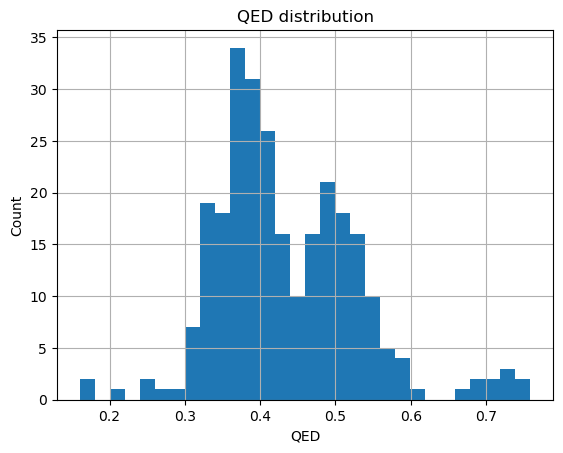

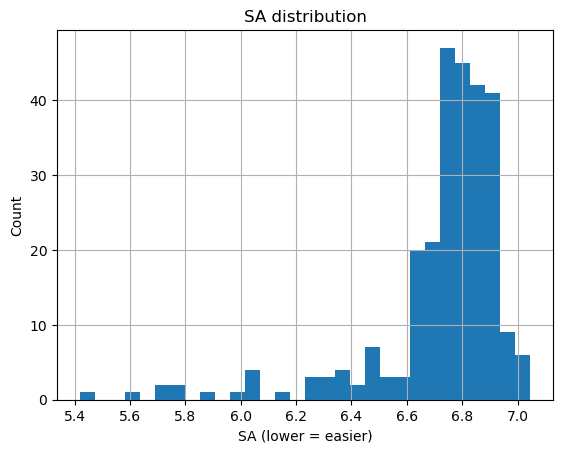

In [43]:
import matplotlib.pyplot as plt

plt.figure()
df_clean["QED_fix"].dropna().hist(bins=30)
plt.xlabel("QED"); plt.ylabel("Count"); plt.title("QED distribution"); plt.show()

plt.figure()
df_clean["SA_fix"].dropna().hist(bins=30)
plt.xlabel("SA (lower = easier)"); plt.ylabel("Count"); plt.title("SA distribution"); plt.show()


In [44]:
for col in ["QED_fix","SA_fix"]:
    a = df_clean.loc[df_clean["label"]==1, col].dropna()
    b = df_clean.loc[df_clean["label"]==0, col].dropna()
    print(col, "actives mean=", np.round(a.mean(),3), "inactives mean=", np.round(b.mean(),3))


QED_fix actives mean= 0.419 inactives mean= 0.465
SA_fix actives mean= 6.802 inactives mean= 6.6


- QED（0–1，越高越好）：衡量“像药”的程度（综合 MW、LogP、HBA/HBD、芳香性、PSA、可旋转键、警告结构等）。
    - 数据阶段：当作质量控制。如果你的集合平均 QED 很低（比如 <0.4），说明可能混入了不太药性的结构。
- SA（~1–10，越低越好）：衡量“合成难度”的粗略 proxy。
    - 数据阶段：看你的集合是否基本可合成。若多数 >8，就要警惕数据清洗或筛选阈值


---

# Lightweight STONED-SELFIES Expansion


In [55]:

import selfies as sf
from rdkit.Chem.SaltRemover import SaltRemover
from tqdm import tqdm 
import random


In [56]:

def smiles_to_selfies_safe(smi):
    m = to_mol(smi, sanitize=True)
    if m is None:
        return None
    can = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
    try:
        return sf.encoder(can)
    except Exception:
        return None

def mutate_selfies(s, num_mutations=1, alphabet=None):
    if s is None:
        return None
    try:
        if alphabet is None:
            alphabet = list(sf.get_alphabet_from_selfies([s]))
        else:
            alphabet = list(alphabet)
        # ensure tokens is a list (sf.split_selfies may return a generator)
        tokens = list(sf.split_selfies(s))
    except Exception:
        return None

    for _ in range(max(1, int(num_mutations))):
        if not tokens:
            break
        r = random.random()
        # weighted: substitution (70%), insertion (20%), deletion (10%)
        if r < 0.7:
            # substitution
            idx = random.randrange(len(tokens))
            tokens[idx] = random.choice(alphabet)
        elif r < 0.9:
            # insertion
            idx = random.randrange(len(tokens) + 1)
            tokens.insert(idx, random.choice(alphabet))
        else:
            # deletion (only if more than 1 token)
            if len(tokens) > 1:
                idx = random.randrange(len(tokens))
                tokens.pop(idx)

    try:
        return "".join(tokens)
    except Exception:
        return None

def selfies_to_smiles_safe(s):
    try:
        smi = sf.decoder(s)
        m = to_mol(smi, sanitize=True)
        if m is None:
            return None
        return Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
    except Exception:
        return None


In [57]:

seed_selfies = [smiles_to_selfies_safe(s) for s in df_clean["canonical_smiles"]]
seed_selfies = [s for s in seed_selfies if s]
len(seed_selfies)


269

In [60]:

per_seed = 5
mutations = 1
random.seed(123)

mutated = []
for s in tqdm(seed_selfies, desc="Mutating SELFIES"):
    alphabet = sf.get_alphabet_from_selfies([s])
    for _ in range(per_seed):
        mutated.append(mutate_selfies(s, num_mutations=mutations, alphabet=alphabet))

len(mutated)


Mutating SELFIES: 100%|██████████| 269/269 [00:00<00:00, 2211.83it/s]


1345

In [61]:

remover = SaltRemover()
clean_smiles = []
seen = set()

for s in tqdm(mutated, desc="Decoding & cleaning"):
    smi = selfies_to_smiles_safe(s)
    if smi is None:
        continue
    m = to_mol(smi, sanitize=True)
    if m is None:
        continue
    try:
        m = remover.StripMol(m, dontRemoveEverything=True)
        frags = Chem.GetMolFrags(m, asMols=True)
        if not frags:
            continue
        m = max(frags, key=lambda x: x.GetNumAtoms())
        Chem.SanitizeMol(m)
        can = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
        if can in seen:
            continue
        seen.add(can)
        clean_smiles.append(can)
    except Exception:
        continue

len(clean_smiles)


Decoding & cleaning: 100%|██████████| 1345/1345 [00:04<00:00, 281.69it/s]


1312

In [ ]:
from rdkit import Chem
from rdkit.Chem import QED
import pandas as pd
import numpy as np
import os

def to_mol(smi):
    m = Chem.MolFromSmiles(smi, sanitize=False)
    if m is None:
        return None
    try:
        Chem.SanitizeMol(m)
        return m
    except Exception:
        return None

def sa_score_simple(mol):
    from rdkit.Chem import Descriptors, rdMolDescriptors
    if mol is None:
        return np.nan
    try:
        mw   = Descriptors.MolWt(mol)
        ri   = mol.GetRingInfo()
        nring = ri.NumRings()
        nrot = rdMolDescriptors.CalcNumRotatableBonds(mol)
        tpsa = rdMolDescriptors.CalcTPSA(mol)
        frac_csp3 = rdMolDescriptors.CalcFractionCSP3(mol)
        n_hetero = sum(1 for a in mol.GetAtoms() if a.GetAtomicNum() not in (1,6))
        n_arom   = sum(1 for a in mol.GetAtoms() if a.GetIsAromatic())
        natoms   = mol.GetNumAtoms()
        arom_frac = (n_arom / natoms) if natoms>0 else 0.0
        raw = (0.002*mw + 0.80*nring + 0.15*nrot + 0.25*n_hetero + 0.01*tpsa + 1.0*arom_frac - 0.50*frac_csp3)
        raw = max(0.0, raw)
        return float(1.0 + 9.0*(raw/(raw+6.0)))
    except Exception:
        return np.nan

q_list, s_list = [], []
for smi in clean_smiles:
    m = to_mol(smi)
    if m is None:
        q_list.append(np.nan); s_list.append(np.nan); continue
    try: q = float(QED.qed(m))
    except Exception: q = np.nan
    s = sa_score_simple(m)
    q_list.append(q); s_list.append(s)

df_exp_all = pd.DataFrame({"smiles": clean_smiles, "QED": q_list, "SA": s_list})
print("Total rows:", len(df_exp_all))
print("Valid QED:", df_exp_all['QED'].notna().sum(), " | Valid SA:", df_exp_all['SA'].notna().sum())


out_all = "expanded_candidates_all.csv"
df_exp_all.to_csv(out_all, index=False, encoding="utf-8")


df_exp_scored = df_exp_all.dropna(subset=["QED","SA"]).reset_index(drop=True)
out_scored = "expanded_candidates_scored.csv"
df_exp_scored.to_csv(out_scored, index=False, encoding="utf-8")

# SELFIES .txt
import selfies as sf
def smi_to_selfies_safe(s):
    try:
        m = to_mol(s)
        if m is None: return None
        can = Chem.MolToSmiles(m, isomericSmiles=True, canonical=True)
        return sf.encoder(can)
    except Exception:
        return None

selfies_exp = [smi_to_selfies_safe(s) for s in df_exp_all["smiles"]]
selfies_exp = [s for s in selfies_exp if s]
out_selfies = "expanded_candidates.selfies.txt"
with open(out_selfies, "w", encoding="utf-8") as f:
    for s in selfies_exp:
        f.write(s + "\n")

print("[OK] Saved:")
print("  ", os.path.abspath(out_all))
print("  ", os.path.abspath(out_scored))
print("  ", os.path.abspath(out_selfies))
df_exp_all.head()


Total rows: 1312
Valid QED: 1312  | Valid SA: 1312
[OK] Saved:
   /Users/lishixidaxiaojie/Desktop/ECE 733/project/data/expanded_candidates_all.csv
   /Users/lishixidaxiaojie/Desktop/ECE 733/project/data/expanded_candidates_scored.csv
   /Users/lishixidaxiaojie/Desktop/ECE 733/project/data/expanded_candidates.selfies.txt


,smiles,QED,SA
0,C=CC(=O)N1CCC2c3[nH]n(c(=NCOC[C@@H]4CCCN4C)c3C...,0.377629,6.636756
1,C=CC(=O)N1CCN(N=NC(=NC2=CCCN(c3cc(O)cc4ccccc34...,0.263663,6.507408
2,C=CC1CCN(c2nc(OC[C@@H]3CCCN3C)nc3c2CCN(c2cc(O)...,0.482288,6.557652
3,C=CC(=O)NCC1CCN1c1nc(OC[C@@H]2CCCN2C)ncc1C1CN(...,0.339257,6.789266
4,C=CC(=O)NC1CCN(C=NC(C=NC2=CCCN(c3cc(O)cc4ccccc...,0.171895,6.704680
